In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from typing import Dict, List, Tuple

import numpy as np
from PIL import Image

from pysolotools.consumers import Solo
from pysolotools.converters.solo2coco import SOLO2COCOConverter
from pysolotools.core.models import KeypointAnnotationDefinition, RGBCameraCapture
from pysolotools.core.models import BoundingBox2DLabel, BoundingBox2DAnnotation
from pysolotools.core.models import BoundingBox3DLabel, BoundingBox3DAnnotation
from pysolotools.core.models import Frame, Capture

from scipy.spatial.transform import Rotation as R

from torchvision.datasets import ImageFolder
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
# from torch.utils.data import ConcatDataset, DataLoader

import torch
from torch import nn

from scipy.io import savemat, loadmat
from mmdet.apis import DetInferencer
# from mmdet.apis import init_detector, inference_detector, show_result_pyplot

from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.io import savemat, loadmat

import utils
import reader
# %matplotlib ipympl

In [3]:
train_folder = 'D:/Unity/dataset/solo'
# training_dir = './data/train'
# testing_dir = './data/test'

In [4]:
# Initialize the DetInferencer
inferencer = DetInferencer('detr_r50_8xb2-150e_coco', show_progress=False)


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v3.0/detr/detr_r50_8xb2-150e_coco/detr_r50_8xb2-150e_coco_20221023_153551-436d03e8.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

01/21 17:58:32 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


c:\Users\LeonardNgo\miniconda3\envs\cvmpa\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


2D object detection

bbox -> AoD

Save argument for each "scene" \
    - 3D position of UEs and SBSs\
    - AoD of visible UEs from each camera\
    - 3D

In [21]:
min_req, max_req = 0.1, 0.1
threshold = 0.7
solo = Solo(data_path=train_folder)
category_lookup = {v: k-1 for k, v in solo.categories().items()}
all_predictions, all_labels = [], []
for frame_idx, frame in enumerate(solo.frames()):
    # print(f'\rProcessing: {100*(frame_idx+1)/len(solo.frames()):.2f}% | {train_folder}/sequence.{frame.sequence}', end='')

    objects = {}
    sbs_positions = {}
    capture_lookup = {}
    for capture in frame.captures:
        if capture.id not in sbs_positions:
            sbs_positions[capture.id] = capture.position
        if capture.id not in capture_lookup:
            capture_lookup[capture.id] = len(capture_lookup)

        anno_3d = [
            anno for anno in capture.annotations 
            if isinstance(anno, BoundingBox3DAnnotation)
        ][0]
        if len(anno_3d.values) == 0: continue
        
        r = R.from_quat(capture.rotation)
        for bbox in anno_3d.values:
            # add new UE
            if bbox.labelName == 'phone':
                if bbox.instanceId not in objects:
                    objects[bbox.instanceId] = reader.Object(
                        instanceId=bbox.instanceId,
                        category=np.zeros(len(category_lookup)),
                        position=np.array(r.apply(bbox.translation)+capture.position),
                        los=np.zeros(len(frame.captures)),
                        required_rate=np.array([-1]),
                        ca=np.zeros(len(frame.captures)),
                    )
                    objects[bbox.instanceId].category[category_lookup[bbox.labelName]] = 1
                    if bbox.labelName == 'phone':
                        objects[bbox.instanceId].required_rate = np.random.rand(1)*(max_req-min_req) + min_req

                objects[bbox.instanceId].los[capture_lookup[capture.id]] = 1
    if len(objects) == 0: continue
    
    # save the 3D positions all UEs
    # savemat(
    #     f'{train_folder}/sequence.{frame.sequence}/objects.mat',
    #     {
    #         'instanceId': np.array([obj.instanceId for obj in objects.values()]),
    #         'category': np.array([obj.category for obj in objects.values()]),
    #         'position': np.array([obj.position for obj in objects.values()]),
    #         'required_rate': np.array([obj.required_rate for obj in objects.values()]),
    #         'los': np.array([obj.los for obj in objects.values()]),
    #     }
    # )
    # # save the 3D positions all SBSs
    # savemat(
    #     f'{train_folder}/sequence.{frame.sequence}/sbs.mat',
    #     {
    #         'position': np.array([
    #             position for position in sbs_positions.values()
    #         ]),
    #     }
    # )

    for capture in frame.captures:
        # bbox_2d = {}
        rotation = R.from_quat(capture.rotation)
        position = np.array(capture.position)
        resolution = np.array(capture.dimension)

        intrinsic = np.array(capture.matrix).reshape((3, 3))
        intrinsic /= intrinsic[-1,-1]
        intrinsic *= np.array([*resolution, 1])*np.array([-.5, .5, 1])
        intrinsic[-1, 0] = resolution[0]/2
        intrinsic[-1, 1] = resolution[1]/2
        
        # perform 2D object detection
        path = f'{train_folder}/sequence.{frame.sequence}'
        output = inferencer(f'{path}/{capture.filename}')

        # get class scores of targeted classes
        prediction = output['predictions'][0]
        phone_ids = [i for i, idx in enumerate(prediction['labels']) if idx == 2]  # 67: phone
        # phone_scores = [prediction['scores'][i] for i in phone_ids]
        phone_scores = []  # list of predictions
        for idx, label in enumerate(prediction['labels']):
            if label != 67: continue
            bbox = prediction['bboxes'][idx]
            dimension = np.array([bbox[2]-bbox[0], bbox[3]-bbox[1]])
            phone_scores.append([
                prediction['scores'][idx],
                np.array([bbox[0], bbox[2]]) + dimension/2,
            ])

        # filter out the low confidence detections
        filter_ids = [i for i in phone_ids if prediction['scores'][i] >= threshold]
        phone_bboxes = [prediction['bboxes'][i] for i in filter_ids]

        # convert the bbox -> centroid -> AoD
        centers = [(np.array(bbox[:2]) + np.array(bbox[2:]))/2 for bbox in phone_bboxes]
        aods = [
            np.array([c[0], c[1], 1]) @ np.linalg.inv(intrinsic) @ rotation.as_matrix().T
            for c in centers
        ]
        # aods = [np.array(aod[0], aod[1], aod[2]) for aod in aods]
        aods = [
            np.array(np.arctan2(aod[2], aod[0]), np.arctan2(aod[1], np.linalg.norm(aod[0]+aod[2])))
            for aod in aods
        ]

        # assign instanceId to each AoD
        aodId = [-1 for _ in aods]

        # retreiving list of labels
        anno_2d = [
            anno for anno in capture.annotations 
            if isinstance(anno, BoundingBox2DAnnotation)
        ][0]  # annotation for 2D BBox
        bbox_2d = {
            bbox.instanceId: np.array(bbox.origin) + np.array(bbox.dimension)/2
            for bbox in anno_2d.values
        }  # list of labels
        # pair predictions to labels
        if len(bbox_2d) == 0 or len(phone_scores) == 0: 
            pred_ids, label_ids = [], []
        else:
            distances = cdist(
                np.array([bbox for bbox in bbox_2d.values()]),
                np.array([pred[1] for pred in phone_scores])
            )
            label_ids, pred_ids = linear_sum_assignment(distances)
            
        
        if (a:=len(phone_scores)) < (b:=len(bbox_2d)):  # when there are less predictions than labels
            _temp = b-a
            predictions = [phone_scores[idx][0] for idx in pred_ids] + [0]*_temp #+ [1]
            labels = [1]*b #+ [0]
        else:  # when there are more predictions than labels
            _temp = a-b
            # there are b labels and _temp false positives
            _ids = [idx for idx in list(range(len(phone_scores))) if idx not in pred_ids]
            predictions = [phone_scores[idx][0] for idx in pred_ids] + [phone_scores[idx][0] for idx in _ids]
            # predictions = [score[0] for score in phone_scores]
            labels = [1]*b + [0]*_temp

        all_predictions.extend(predictions)
        all_labels.extend(labels)

        if len(centers) > 0:
            _bboxes = [bbox for bbox in anno_2d.values if bbox.labelName == 'phone']
            for bbox in _bboxes:
                label_center = np.array(bbox.origin) + np.array(bbox.dimension)/2
                best_idx = None
                min_dist = np.inf
                for idx, center in enumerate(centers):
                    dist = np.linalg.norm(label_center - center)
                    if dist < min_dist:
                        min_dist = dist
                        best_idx = idx
                aodId[best_idx] = bbox.instanceId
        # savemat(
        #     f'{path}/{capture.id}.mat',
        #     {
        #         'instanceId': np.array([obj.instanceId for obj in objects.values()]),
        #         'category': np.array([obj.category for obj in objects.values()]),
        #         'position': np.array([obj.position for obj in objects.values()]),
        #         'required_rate': np.array([obj.required_rate for obj in objects.values()]),
        #         'los': np.array([obj.los for obj in objects.values()]),
        #         'aod': np.array(aods),
        #         'aodId': np.array(aodId)
        #     }
        # )
    # if frame_idx == 1: break


To measure TPR and FPR for ROC, we need to obtain the list of predictions and the list of labels.

As 2D OD (DETR) operates on each image, we average ROC over cameras.

In each cameras, we obtain the list of predictions and the list of labels. \
If there is less predictions than labels, we append empty objects to prediction list and consider them as false negatives. \
If there is more predictions than labels, we append empty object to label list and consider them as false positives.


In [22]:
all_labels.count(0)

229

In [23]:
if all_labels.count(0) == 0:
    all_labels.append(0)
    all_predictions.append(1)

In [27]:
cvca_roc = loadmat('./cvca_det_roc.mat')
cvca_labels, cvca_predictions = cvca_roc['label'][0], cvca_roc['pred'][0]
fpr_2, tpr_2, thresholds = roc_curve(cvca_labels, cvca_predictions, pos_label=0) #, drop_intermediate=False)

# store the fpr, tpr, and roc_auc for all averaging strategies
# fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr_1, tpr_1, thresholds = roc_curve(all_labels, all_predictions, pos_label=1) #, drop_intermediate=False)
# fpr_1, tpr_1, thresholds

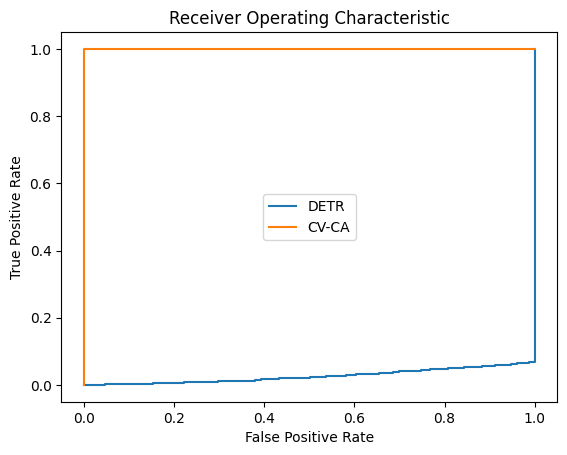

In [28]:

# plt.plot([0,1],[0,1], 'k--')
# plt.plot(fpr1, tpr1, label= "Linear")
# plt.plot(fpr2, tpr2, label= "Poly")
# plt.plot(fpr3, tpr3, label= "RBF")
plt.plot(fpr_1, tpr_1, label= "DETR")
plt.plot(fpr_2, tpr_2, label= "CV-CA")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.show()

In [ ]:


from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    all_labels, all_predictions,
    pos_label=1,
    name='DETR',
    color="darkorange",
    plot_chance_level=False,
)
# RocCurveDisplay.from_predictions(
#     all_labels, all_predictions,
#     pos_label=1,
#     name='abc',
#     color="darkorange",
#     plot_chance_level=True,
# )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve of UE detection")
plt.legend()
plt.show()